## 1. Define Function

In [13]:
import numpy as np
#return discount rate between each deltaT
def generateBT(r0,drift,sigma,n,year): 
    BT=[[r0]]
    deltaT=1/n
    for i in range(0,n*year):
        currentR=BT[i].copy()
        lastTerm=currentR[i]*np.exp(drift*deltaT-sigma*np.sqrt(deltaT))
        currentR=np.array(currentR)*np.exp(drift*deltaT+sigma*np.sqrt(deltaT))
        currentR=currentR.tolist()
        currentR.append(lastTerm)
        BT.append(currentR)
    for i in range(0,len(BT)):
        for j in range(0,len(BT[i])):
            BT[i][j] = np.exp(- BT[i][j]*deltaT)
    return BT

In [14]:
#return interst rate of each node
def generateBTR(r0,drift,sigma,n,year): 
    BT=[[r0]]
    deltaT=1/n
    for i in range(0,n*year):
        currentR=BT[i].copy()
        lastTerm=currentR[i]*np.exp(drift*deltaT-sigma*np.sqrt(deltaT))
        currentR=np.array(currentR)*np.exp(drift*deltaT+sigma*np.sqrt(deltaT))
        currentR=currentR.tolist()
        currentR.append(lastTerm)
        BT.append(currentR)
    return BT

In [15]:
def discountedValue(BT,n):
    result=[BT[n-1].copy()]
    for i in np.arange(n-1,0,-1):
        m=len(result[n-1-i])
        result.append((0.5*(np.array(result[n-1-i][0:m-1])+np.array(result[n-1-i][1:m]))*np.array(BT[i-1])).tolist())
    return result[n-1][0]

In [16]:
'''
r0=current continous conpouding short rate
drift,sigma=parameters in model
n=numer of steps in year
year=matirity
cFrq=how many times of coupon payment per year
c=coupon rate
principle=face value
'''
def vanillaBond(r0,drift,sigma,n,year,cFrq,c,principle):
    BT=generateBT(r0,drift,sigma,n,year)
    price=principle*discountedValue(BT,year*n) 
    for t in np.array(range(1,cFrq*year+1))/cFrq:
        price+=(c/cFrq)*principle*discountedValue(BT,int(t*n))  
    return price    

In [17]:
from scipy.special import comb
def callableBond(r0,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime):
    
    BTRt=generateBTR(r0,drift,sigma,n,callTime)
    BTt=generateBT(r0,drift,sigma,n,callTime)
    newR=BTRt[n*callTime]
    
    price=0
    count=0
    for r in newR:
        p1=min(vanillaBond(r,drift,sigma,n,year-callTime,cFrq,c,principle),callPirce)
        price+=p1*discountedValue(BTt,callTime*n)*comb(len(newR)-1, count)/(2**(len(newR)-1))
        count+=1
        
    for t in np.array(range(1,cFrq*callTime+1))/cFrq:
        price+=(c/cFrq)*principle*discountedValue(BTt,int(t*n))  
    return price

In [18]:
#https://github.com/jamesmawm/Mastering-Python-for-Finance-source-codes/blob/master/B03898_05_Codes/bond_ytm.py
import scipy.optimize as optimize
def ytm(price,c,principle,cFrq,year):
    
    freq = float(cFrq)
    periods = year*freq
    coupon = c*principle/cFrq
    dt = [(i+1)/freq for i in range(int(periods))]
    ytm_func = lambda y: sum([coupon/(1+y/freq)**(freq*t) for t in dt]) + principle/(1+y/freq)**(freq*year) - price
    
    return optimize.newton(ytm_func, 0.03)

In [19]:
#callableBond(0.02,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime)

In [20]:
#vanillaBond(0.02,drift,sigma,n,year,cFrq,c,principle)

## 2. Simulate vanilla bond price

In [21]:
drift=0.01
sigma=0.4
n=2
year=30
cFrq=2
c=0.03
principle=100
callPirce=101
callTime=3

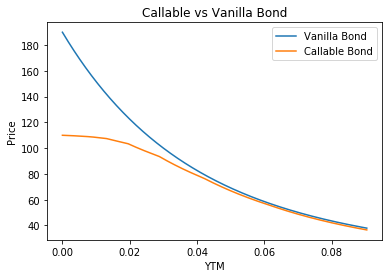

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline
y=[]
price=[]
priceC=[]
for r in np.arange(0,1000)*0.0001:
    p=vanillaBond(r,drift,sigma,n,year,cFrq,c,principle)
    y.append(ytm(p,c,principle,cFrq,year))
    price.append(p)
    priceC.append(callableBond(r,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime))
plt.figure(figsize=(6,4))    
plt.plot(y,price,label='Vanilla Bond') 
plt.plot(y,priceC,label='Callable Bond')
plt.title('Callable vs Vanilla Bond')
plt.xlabel('YTM')
plt.ylabel('Price')
plt.legend()
plt.show()

In [33]:
price = np.array(price)
priceC = np.array(priceC)
y = np.array(y)

print(len(priceC), len(y))

1000 1000


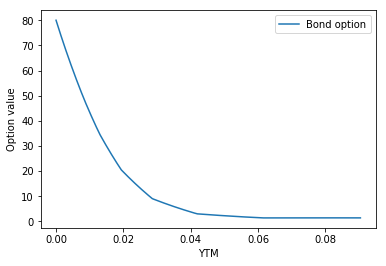

In [29]:
option_value = price - priceC
plt.figure(figsize=(6,4))    
plt.plot(y,option_value,label='Bond option')
plt.xlabel('YTM')
plt.ylabel('Option value')
plt.legend()
plt.show()

In [67]:
def smooth_ave(d, period = 3):
    length = len(d)
    res = np.zeros(length - (period - 1))
    for i in np.arange(period - 1):
        res += d[i:i - period + 1]
        
    res += d[period - 1:length]
    return res / period

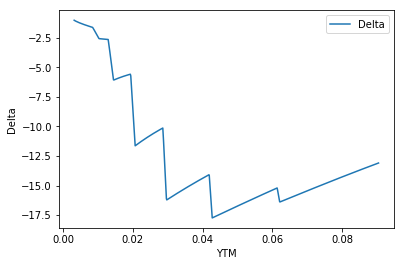

In [68]:
disc1 = 10
delta = ((priceC[disc1:] - priceC[:-disc1]) / priceC[disc1:]) / (y[disc1:] - y[:-disc1])
new_y = y[disc1:]
plt.figure(figsize=(6,4))    
plt.plot(new_y,delta,label='Delta')
plt.xlabel('YTM')
plt.ylabel('Delta')
plt.legend()
plt.show()

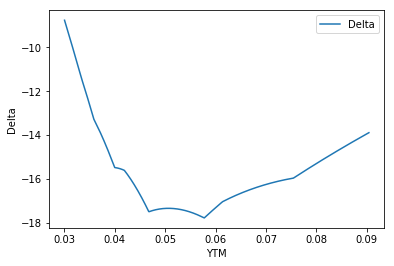

In [79]:
period = 200
priceC_sm = smooth_ave(priceC, period)
disc1 = 1
new_y = y[period - 1:]
delta = ((priceC_sm[disc1:] - priceC_sm[:-disc1]) / (priceC_sm[:-disc1])) / (new_y[disc1:] - new_y[:-disc1])
new_yy = new_y[disc1:]
plt.figure(figsize=(6,4))    
plt.plot(new_yy,delta,label='Delta')
plt.xlabel('YTM')
plt.ylabel('Delta')
plt.legend()
plt.show()

790


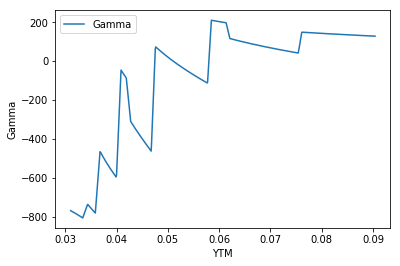

In [83]:
disc2 = 10
gamma = (delta[disc2:] - delta[:-disc2]) / (new_yy[disc2:] - new_yy[:-disc2])

print(len(gamma))

plt.figure(figsize=(6,4))    
plt.plot(new_yy[disc2:],gamma,label='Gamma')
plt.xlabel('YTM')
plt.ylabel('Gamma')
plt.legend()
plt.show()